In [45]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
import copy
import requests
from concurrent.futures import ThreadPoolExecutor

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import norm
from pypfopt.expected_returns import ema_historical_return, capm_return
from pypfopt.risk_models import exp_cov, fix_nonpositive_semidefinite, CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt import objective_functions
from pypfopt import base_optimizer
import optuna

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import utils as ut

## Global Settings

In [3]:
seed = 1227
rs = np.random.RandomState(seed)

mpl.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings('ignore')

horizon = 21 * 16

## Data

In [4]:
in_sample_data = pd.read_parquet('../data/in_sample_data.parquet')
out_sample_data = pd.read_parquet('../data/out_sample_data.parquet')
nasdaq = pd.read_csv('../data/nasdaq_100.csv', index_col=0)

in_sample_data.shape, out_sample_data.shape, nasdaq.shape

((1260, 30), (334, 30), (1594, 1))

We create a dictionary of ticker-sector key value pairs for use later when we add sector constraints:

In [5]:
# Sector mappings
nasdaq_obj = ut.Nasdaq100(in_sample_data.columns.tolist())
sector_mappings = {ticker: sector for ticker, sector in zip(nasdaq_obj.tickers, nasdaq_obj.get_industries())}
sector_mappings

{'AAPL': 'Technology',
 'AEP': 'Utilities',
 'AMZN': 'Retail',
 'BIIB': 'Healthcare',
 'CMCSA': 'Telecom',
 'CME': 'Financial Services',
 'COST': 'Retail',
 'CSCO': 'Technology',
 'EA': 'Technology',
 'EBAY': 'Retail',
 'GOOG': 'Technology',
 'HD': 'Retail',
 'HON': 'Manufacturing',
 'INTC': 'Technology',
 'JPM': 'Financial Services',
 'LULU': 'Retail',
 'META': 'Technology',
 'MSFT': 'Technology',
 'NFLX': 'Media & Entertainment',
 'NVDA': 'Technology',
 'ORLY': 'Consumer Discretionary',
 'PEP': 'Consumer Staples',
 'PFE': 'Healthcare',
 'QCOM': 'Technology',
 'SBUX': 'Consumer Discretionary',
 'TSLA': 'Consumer Discretionary',
 'TXN': 'Technology',
 'VRTX': 'Healthcare',
 'WDAY': 'Technology',
 'XEL': 'Utilities'}

In [18]:
# Open prices
open_prices = nasdaq_obj.get_prices('2022-09-27').T.iloc[:, 0]
open_prices

[*********************100%***********************]  30 of 30 completed


AAPL     152.740005
AEP       95.879997
AMZN     117.199997
BIIB     197.020004
CMCSA     31.280001
CME      180.949997
COST     485.489990
CSCO      41.139999
EA       115.529999
EBAY      38.520000
GOOG      99.910004
HD       269.359985
HON      170.860001
INTC      27.400000
JPM      107.750000
LULU     300.200012
META     137.919998
MSFT     239.979996
NFLX     228.630005
NVDA     125.070000
ORLY     694.590027
PEP      168.240005
PFE       44.220001
QCOM     121.559998
SBUX      85.970001
TSLA     283.839996
TXN      162.229996
VRTX     279.929993
WDAY     149.539993
XEL       70.160004
Name: 2022-09-27 00:00:00, dtype: float64

## Objective Function 

The objective function will allow us to select different combinations of strategies and select the one that performs the best based on a performance metric on the out sample data (past 16 months). The metric we will optimize (maximize) is the sharpe ratio of the portfolio given the following inputs:

* Optimal weights of the optimization model

* Out sample expected returns

* Out sample covariance matrix estimator

* Risk free rate, which is interpolated from the yield curve as follows:

In [21]:
# Child 4 indicates the row of the table corresponding to the most recent day, e.g., 2023-03-06 
# See https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve
selectors = [
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.bc1month.views-field.views-field-field-bc-1month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.bc3month.views-field.views-field-field-bc-3month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-6month',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-1year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-2year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.bc3month.views-field.views-field-field-bc-3year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-5year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-7year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.views-field.views-field-field-bc-10year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.bc20year.views-field.views-field-field-bc-20year',
    '#block-hamilton-content > div > div > div.view-content > table > tbody > tr:nth-child(214) > td.bc30year.views-field.views-field-field-bc-30year'
]

# Function to scrape the yield curve from the treasury.gov website
def get_yield_curve(selector: str) -> float:
    """
    Parameters
    ----------
    selector : str
        A CSS selector string for the yield curve data for a given maturity and date.

    Returns
    -------
    float
        A yield curve value for a given maturity.
    """
    url = 'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2016'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    element = soup.select_one(selector)
    
    return float(element.text.strip()) # Remove leading and trailing whitespace and convert rate to float

with ThreadPoolExecutor() as executor: # Use all available cores
    results = list(executor.map(get_yield_curve, selectors))

Now, we interpolate the 16 month constant maturity rate using cubic interpolation:

In [22]:
# Rates and maturities are in the same order
rates = np.array(results)
maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])

# Create an interpolation function using cubic interpolation
f = interp1d(maturities, rates, kind='cubic')

# Interpolate the 16-month rate
rate_16m = float(f(16/12))

print("Interpolated 16-month rate:", rate_16m)

Interpolated 16-month rate: 0.6820014420816192


We can plot the yield curve using cubic spline:

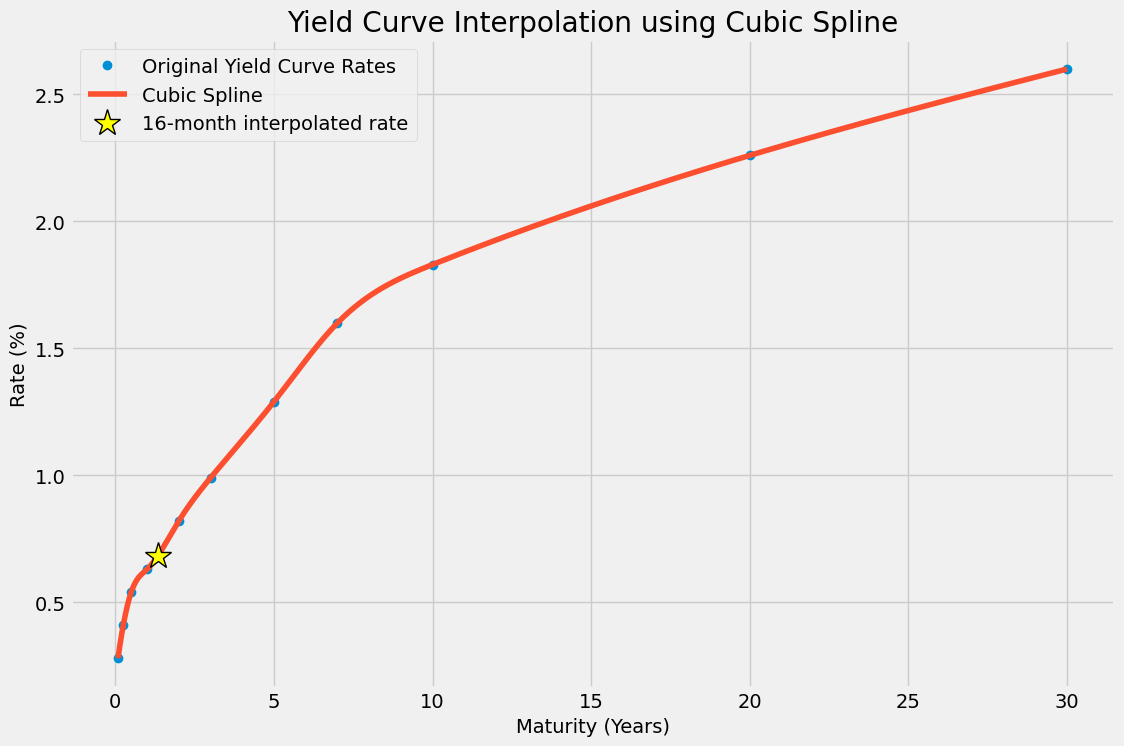

In [23]:
plt.plot(maturities, rates, 'o', label='Original Yield Curve Rates') # Using 'o' (circle marker) to denote the original data points

# Plot the interpolated yield curve using cubic spline
maturities_cubic_spline = np.linspace(maturities.min(), maturities.max(), 1000)
rates_cubic_spline = f(maturities_cubic_spline)
plt.plot(maturities_cubic_spline , rates_cubic_spline, '-', label='Cubic Spline') # Using '-' (solid line) to denote the interpolated data points

# Plot the 16-month interpolated rate
plt.plot(16/12, rate_16m, '*', label='16-month interpolated rate', markersize=20, markerfacecolor='yellow', markeredgecolor='black')

plt.title('Yield Curve Interpolation using Cubic Spline')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate (%)')
plt.legend()

# display the plot
plt.show();

We now split the training sample into training and validation sets:

In [24]:
split_date = in_sample_data.index.max() - pd.DateOffset(months=16)

in_sample_data_train = in_sample_data.loc[:split_date]
in_sample_data_val = in_sample_data.loc[split_date:]

(in_sample_data_train.index.min(), in_sample_data_train.index.max())
(in_sample_data_val.index.min(), in_sample_data_val.index.max())

(Timestamp('2013-08-30 00:00:00'), Timestamp('2017-04-28 00:00:00'))

(Timestamp('2017-05-01 00:00:00'), Timestamp('2018-08-30 00:00:00'))

In [25]:
def objective(trial):
    
    # -------------------------- Initial hyperparameters ------------------------- #
    
    params = {
        'expected_return_model': trial.suggest_categorical('expected_return_model', ['capm', 'exp_weighted']),
        'risk_model': trial.suggest_categorical('risk_model', ['exp_weighted', 'shrinkage']),
        'reg_gamma': trial.suggest_int('reg_gamma', 2, 6)
    }
    
    # ------------------------------- Returns model ------------------------------ #
    
    # If the expected return model is capm, then we need to specify the risk free rate
    if params['expected_return_model'] == 'capm':
        
        returns_train = capm_return(
            prices=in_sample_data_train,
            returns_data=False,
            risk_free_rate=rate_16m,
            frequency=horizon,
            compounding=False
            
        )
        
        returns_val = capm_return(
            prices=in_sample_data_val,
            returns_data=False,
            risk_free_rate=rate_16m,
            frequency=horizon,
            compounding=False
        )
    else:
        # If the expected return model is exp_weighted, then we need to specify the 'span' parameter for the exponential moving average
        params['returns_span'] = trial.suggest_int('returns_span', 200, 700)
        
        returns_train = ema_historical_return(
            prices=in_sample_data_train,
            span=params['returns_span'],
            returns_data=False,
            frequency=horizon,
            compounding=False
        )
        
        returns_val = ema_historical_return(
            prices=in_sample_data_val,
            span=params['returns_span'],
            returns_data=False,
            frequency=horizon,
            compounding=False
        )

    # -------------------------------- Risk model -------------------------------- #
    
    # If the risk model is shrinkage, then we need to specify the shrinkage target
    if params['risk_model'] == 'shrinkage':
        
        params['shrinkage_target'] = trial.suggest_categorical('shrinkage_target', ['constant_variance', 'single_factor', 'constant_correlation'])
        
        shrinkage_model_train = CovarianceShrinkage(prices=in_sample_data_train, returns_data=False, frequency=horizon)
        shrinkage_model_val = CovarianceShrinkage(prices=in_sample_data_val, returns_data=False, frequency=horizon)
        
        cov_train = shrinkage_model_train.ledoit_wolf(params['shrinkage_target'])
        cov_val = shrinkage_model_val.ledoit_wolf(params['shrinkage_target'])
        
        # Check for positive semi-definiteness
        cov_train = fix_nonpositive_semidefinite(cov_train)
        cov_val = fix_nonpositive_semidefinite(cov_val)
        
    else: 
        # If the risk model is exp_weighted, then we need to specify the 'span' parameter for the exponential moving average
        # This allows us to use different spans for the returns and covariance matrices
        params['cov_span'] = trial.suggest_int('cov_span', 150, 300)
        
        cov_train = exp_cov(
            prices=in_sample_data_train,
            returns_data=False,
            span=params['cov_span'],
            frequency=horizon
        )
        
        cov_val = exp_cov(
            prices=in_sample_data_val,
            returns_data=False,
            span=params['cov_span'],
            frequency=horizon
        )
        
        # Check for positive semi-definiteness
        cov_train = fix_nonpositive_semidefinite(cov_train)
        cov_val = fix_nonpositive_semidefinite(cov_val)
        
    # ------------------------------- Optimization ------------------------------- #
    
    # Create the optimization model
    markowitz_model = EfficientFrontier(
        expected_returns=returns_train.to_numpy().flatten(),
        cov_matrix=cov_train,
        weight_bounds=(0, 1), # Assume fully invested portfolio
        solver=None # Use cvxpy’s default choice of solver
    )
    
    # Add sector constraints (the sector_mappings dictionary is scoped from the enclosing environment)
    markowitz_model.add_sector_constraints(
        sector_mapper=sector_mappings, 
        sector_lower={'Technology': 0.1}, # At least 10% of the portfolio should be invested in the Technology sector
        sector_upper={'Technology': 0.3} # At most 20% of the portfolio should be invested in the Technology sector
    )
    
    # Add the regularization term (tuning gamma i.e., the higher the value of gamma, the more non-negligible weights)
    markowitz_model.add_objective(objective_functions.L2_reg, gamma=params['reg_gamma'])
    
    try:
        optimal_weights = markowitz_model.max_sharpe(risk_free_rate=rate_16m)
    except:
        print('Optimization failed')
        return np.inf
    
    # -------------------------------- Evaluation -------------------------------- #
    
    # Out of sample performance
    negated_val_sample_sharpe = objective_functions.sharpe_ratio(
        w=np.array(list(optimal_weights.values())), 
        expected_returns=returns_val.to_numpy().flatten(), 
        cov_matrix=cov_val,
        risk_free_rate=rate_16m,
        negative=True # Calculate the negative sharpe ratio, so we can minimize the optuna objective function
    )
    
    print('Validation sharpe ratio: {}'.format(negated_val_sample_sharpe))
    
    return negated_val_sample_sharpe

In [38]:
# Create the study object
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(), 
    study_name='min_neg_sharpe', 
    direction='minimize', 
    pruner=optuna.pruners.HyperbandPruner() # Prune unpromising trials
)
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2023-03-09 01:23:51,326] A new study created in memory with name: min_neg_sharpe
[I 2023-03-09 01:23:51,659] Trial 3 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 5, 'shrinkage_target': 'single_factor'}. Best is trial 3 with value: inf.


Optimization failed


[I 2023-03-09 01:23:52,855] Trial 5 finished with value: 0.4239168031856432 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 6, 'returns_span': 334, 'shrinkage_target': 'constant_variance'}. Best is trial 5 with value: 0.4239168031856432.
[I 2023-03-09 01:23:52,916] Trial 4 finished with value: 0.6258038001092973 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 265, 'shrinkage_target': 'constant_variance'}. Best is trial 5 with value: 0.4239168031856432.


Validation sharpe ratio: 0.4239168031856432
Validation sharpe ratio: 0.6258038001092973


[I 2023-03-09 01:23:54,157] Trial 6 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 2, 'cov_span': 296}. Best is trial 5 with value: 0.4239168031856432.


Optimization failed
Optimization failed


[I 2023-03-09 01:23:54,322] Trial 1 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 4, 'cov_span': 280}. Best is trial 5 with value: 0.4239168031856432.
[I 2023-03-09 01:23:54,541] Trial 0 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'cov_span': 184}. Best is trial 5 with value: 0.4239168031856432.
[I 2023-03-09 01:23:54,570] Trial 7 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 4, 'cov_span': 213}. Best is trial 5 with value: 0.4239168031856432.


Optimization failed
Optimization failed


[I 2023-03-09 01:23:55,010] Trial 11 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'shrinkage_target': 'constant_variance'}. Best is trial 5 with value: 0.4239168031856432.
[I 2023-03-09 01:23:55,110] Trial 12 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 6, 'shrinkage_target': 'single_factor'}. Best is trial 5 with value: 0.4239168031856432.


Optimization failed
Optimization failed


[I 2023-03-09 01:23:55,302] Trial 9 finished with value: -0.714955374063303 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 648, 'shrinkage_target': 'constant_variance'}. Best is trial 9 with value: -0.714955374063303.


Validation sharpe ratio: -0.714955374063303


[I 2023-03-09 01:23:55,600] Trial 8 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 6, 'cov_span': 276}. Best is trial 9 with value: -0.714955374063303.
[I 2023-03-09 01:23:55,660] Trial 15 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 4, 'shrinkage_target': 'constant_variance'}. Best is trial 9 with value: -0.714955374063303.
[I 2023-03-09 01:23:55,747] Trial 16 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'shrinkage_target': 'constant_correlation'}. Best is trial 9 with value: -0.714955374063303.


Optimization failed
Optimization failed
Optimization failed


[I 2023-03-09 01:23:56,150] Trial 2 finished with value: -0.19106999380242393 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 468, 'cov_span': 198}. Best is trial 9 with value: -0.714955374063303.


Validation sharpe ratio: -0.19106999380242393


[I 2023-03-09 01:23:56,638] Trial 17 finished with value: -0.7229887762597594 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 690, 'shrinkage_target': 'constant_variance'}. Best is trial 17 with value: -0.7229887762597594.


Validation sharpe ratio: -0.7229887762597594


[I 2023-03-09 01:23:57,071] Trial 18 finished with value: -0.7206183726109568 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 5, 'returns_span': 677, 'shrinkage_target': 'constant_variance'}. Best is trial 17 with value: -0.7229887762597594.


Validation sharpe ratio: -0.7206183726109568


[I 2023-03-09 01:23:57,458] Trial 19 finished with value: -0.7173645753786698 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 5, 'returns_span': 660, 'shrinkage_target': 'constant_variance'}. Best is trial 17 with value: -0.7229887762597594.
[I 2023-03-09 01:23:57,464] Trial 13 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 6, 'cov_span': 291}. Best is trial 17 with value: -0.7229887762597594.


Validation sharpe ratio: -0.7173645753786698
Optimization failed
Optimization failed


[I 2023-03-09 01:23:57,660] Trial 14 finished with value: inf and parameters: {'expected_return_model': 'capm', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'cov_span': 219}. Best is trial 17 with value: -0.7229887762597594.
[I 2023-03-09 01:23:57,806] Trial 20 finished with value: -0.7141305021370434 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 5, 'returns_span': 644, 'shrinkage_target': 'constant_variance'}. Best is trial 17 with value: -0.7229887762597594.
[I 2023-03-09 01:23:57,963] Trial 10 finished with value: 0.4102946147688405 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 4, 'returns_span': 331, 'cov_span': 277}. Best is trial 17 with value: -0.7229887762597594.


Validation sharpe ratio: -0.7141305021370434
Validation sharpe ratio: 0.4102946147688405


[I 2023-03-09 01:23:58,357] Trial 22 finished with value: -0.7222698545369333 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 686, 'shrinkage_target': 'constant_variance'}. Best is trial 17 with value: -0.7229887762597594.
[I 2023-03-09 01:23:58,386] Trial 23 finished with value: -0.7137582891994491 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 5, 'returns_span': 685, 'shrinkage_target': 'constant_correlation'}. Best is trial 17 with value: -0.7229887762597594.
[I 2023-03-09 01:23:58,415] Trial 24 finished with value: -0.7156972432344686 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 5, 'returns_span': 696, 'shrinkage_target': 'constant_correlation'}. Best is trial 17 with value: -0.7229887762597594.
[I 2023-03-09 01:23:58,490] Trial 25 finished with value: -0.713036265657346 and parameters: {'expected_return_model':

Validation sharpe ratio: -0.7222698545369333
Validation sharpe ratio: -0.7137582891994491
Validation sharpe ratio: -0.7156972432344686
Validation sharpe ratio: -0.713036265657346
Validation sharpe ratio: -0.7162145106444076


[I 2023-03-09 01:23:58,600] Trial 27 finished with value: -0.38683011785744237 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 5, 'returns_span': 499, 'shrinkage_target': 'constant_correlation'}. Best is trial 17 with value: -0.7229887762597594.
[I 2023-03-09 01:23:58,607] Trial 28 finished with value: -0.7242252575239364 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 5, 'returns_span': 697, 'shrinkage_target': 'constant_variance'}. Best is trial 28 with value: -0.7242252575239364.
[I 2023-03-09 01:23:58,721] Trial 21 finished with value: -0.7054472616882779 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'exp_weighted', 'reg_gamma': 3, 'returns_span': 690, 'cov_span': 154}. Best is trial 28 with value: -0.7242252575239364.
[I 2023-03-09 01:23:58,744] Trial 29 finished with value: -0.724746930181322 and parameters: {'expected_return_model': 'exp_weighted', 'risk_

Validation sharpe ratio: -0.38683011785744237
Validation sharpe ratio: -0.7242252575239364
Validation sharpe ratio: -0.7054472616882779
Validation sharpe ratio: -0.724746930181322
Validation sharpe ratio: -0.6918062947281433


[I 2023-03-09 01:23:58,871] Trial 31 finished with value: -0.6897502039370408 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 546, 'shrinkage_target': 'constant_variance'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:58,888] Trial 32 finished with value: -0.6891521171397538 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 544, 'shrinkage_target': 'constant_variance'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:58,927] Trial 33 finished with value: -0.6906384054740896 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 549, 'shrinkage_target': 'constant_variance'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:58,963] Trial 35 finished with value: -0.6973789599164816 and parameters: {'expected_return_model': 'exp_we

Validation sharpe ratio: -0.6897502039370408
Validation sharpe ratio: -0.6891521171397538
Validation sharpe ratio: -0.6906384054740896
Validation sharpe ratio: -0.6973789599164816


[I 2023-03-09 01:23:59,079] Trial 34 finished with value: -0.7002664370816016 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 3, 'returns_span': 584, 'shrinkage_target': 'constant_variance'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:59,122] Trial 36 finished with value: -0.6979129439204177 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 4, 'returns_span': 575, 'shrinkage_target': 'constant_variance'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:59,176] Trial 37 finished with value: -0.6952016471611374 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 4, 'returns_span': 565, 'shrinkage_target': 'constant_variance'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:59,257] Trial 38 finished with value: -0.7002664370815974 and parameters: {'expected_return_model': 'exp_we

Validation sharpe ratio: -0.7002664370816016
Validation sharpe ratio: -0.6979129439204177
Validation sharpe ratio: -0.6952016471611374
Validation sharpe ratio: -0.7002664370815974


[I 2023-03-09 01:23:59,307] Trial 39 finished with value: -0.690614919201189 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 4, 'returns_span': 597, 'shrinkage_target': 'single_factor'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:59,342] Trial 40 finished with value: -0.6929767933398239 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 4, 'returns_span': 607, 'shrinkage_target': 'single_factor'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:59,421] Trial 41 finished with value: -0.6915699798789693 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 4, 'returns_span': 601, 'shrinkage_target': 'single_factor'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:59,487] Trial 42 finished with value: -0.6943535331775782 and parameters: {'expected_return_model': 'exp_weighted', 'ris

Validation sharpe ratio: -0.690614919201189
Validation sharpe ratio: -0.6929767933398239
Validation sharpe ratio: -0.6915699798789693
Validation sharpe ratio: -0.6943535331775782
Validation sharpe ratio: -0.6972376853964736


[I 2023-03-09 01:23:59,530] Trial 44 finished with value: -0.6970204794955857 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 4, 'returns_span': 625, 'shrinkage_target': 'single_factor'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:59,548] Trial 45 finished with value: -0.698525160598124 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 4, 'returns_span': 632, 'shrinkage_target': 'single_factor'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:59,576] Trial 46 finished with value: -0.7064061041626952 and parameters: {'expected_return_model': 'exp_weighted', 'risk_model': 'shrinkage', 'reg_gamma': 2, 'returns_span': 609, 'shrinkage_target': 'constant_variance'}. Best is trial 29 with value: -0.724746930181322.
[I 2023-03-09 01:23:59,597] Trial 47 finished with value: -0.708256177112182 and parameters: {'expected_return_model': 'exp_weighted', '

Validation sharpe ratio: -0.6970204794955857
Validation sharpe ratio: -0.698525160598124
Validation sharpe ratio: -0.7064061041626952
Validation sharpe ratio: -0.708256177112182
Validation sharpe ratio: -0.7153636544527984
Validation sharpe ratio: -0.712233000659814


In [39]:
# Plot the optimization history
optuna.visualization.plot_optimization_history(study)

## Tuned Portfolio Strategy

In [40]:
study.best_params

{'expected_return_model': 'exp_weighted',
 'risk_model': 'shrinkage',
 'reg_gamma': 3,
 'returns_span': 700,
 'shrinkage_target': 'constant_variance'}

In [26]:
# Returns and risk models
returns_models = {}
risk_models = {}
for sample, data in zip(['train', 'val', 'test'], [in_sample_data_train, in_sample_data_val, out_sample_data]):
    
    returns_models[sample] = ema_historical_return(
        prices=data,
        span=study.best_params['returns_span'],
        returns_data=False,
        frequency=horizon,
        compounding=True
    )
    
    risk_models[sample] = fix_nonpositive_semidefinite(
        CovarianceShrinkage(
            prices=data,
            returns_data=False,
            frequency=horizon
        ).ledoit_wolf(study.best_params['shrinkage_target'])
    )

In [27]:
# Create the optimization model
markowitz_model = EfficientFrontier(
    expected_returns=returns_models['train'].to_numpy().flatten(),
    cov_matrix=risk_models['train'],
    weight_bounds=(0, 1), # Assume fully invested portfolio
    solver=None # Use cvxpy’s default choice of solver
)

# Add sector constraints (the sector_mappings dictionary is scoped from the enclosing environment)
markowitz_model.add_sector_constraints(
    sector_mapper=sector_mappings, 
    sector_lower={'Technology': 0.1}, # At least 10% of the portfolio should be invested in the Technology sector
    sector_upper={'Technology': 0.3} # At most 20% of the portfolio should be invested in the Technology sector
)

# Add the regularization term (tuning gamma i.e., the higher the value of gamma, the more non-negligible weights)
markowitz_model.add_objective(objective_functions.L2_reg, gamma=study.best_params['reg_gamma'])

Plot the efficient frontier:

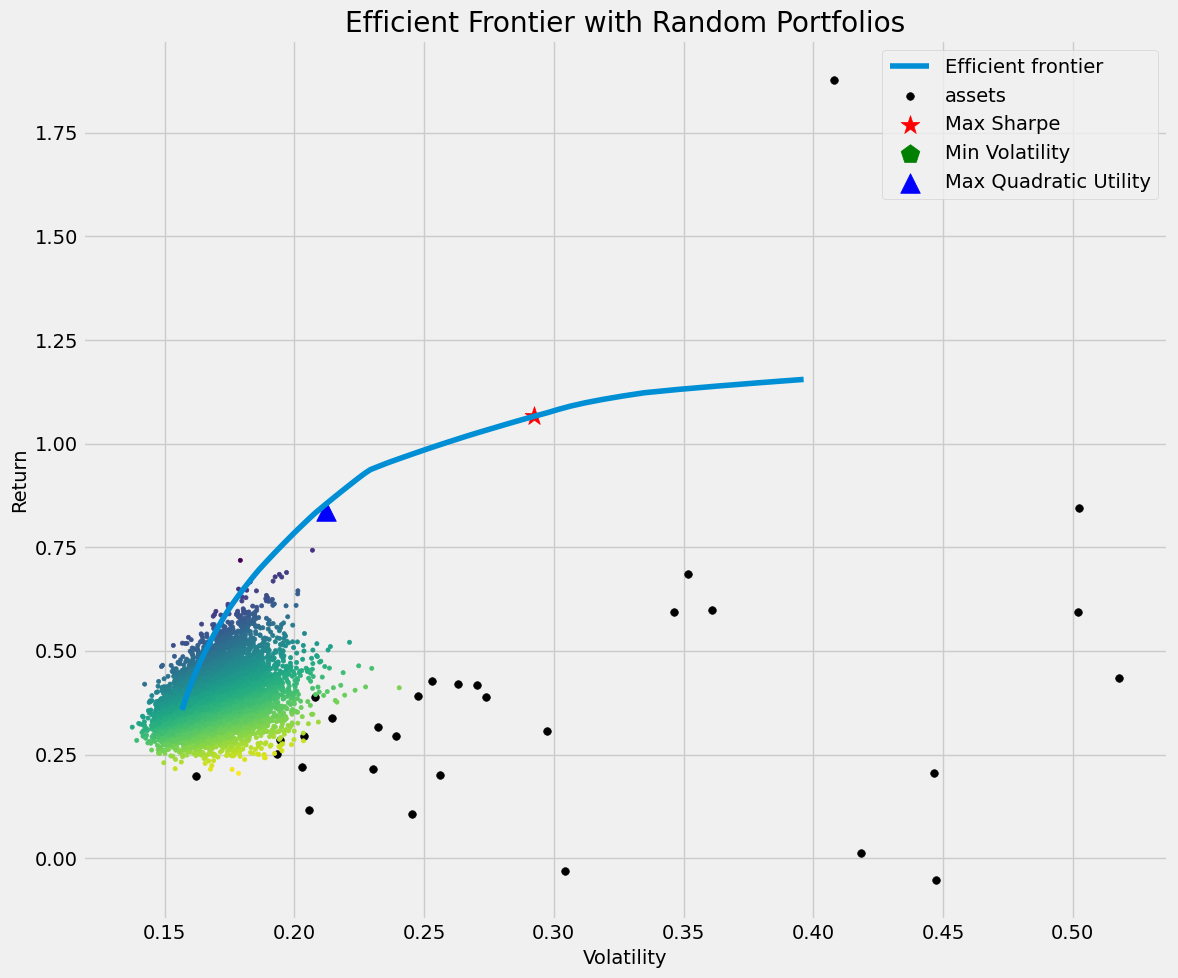

In [28]:
ut.custom_efficient_frontier(markowitz_model, risk_free_rate=rate_16m);

Optimize for sharpe ratio and obtain the optimal weights:

In [29]:
optimal_weights = markowitz_model.max_sharpe(risk_free_rate=rate_16m)
optimal_weights_array = np.array(list(optimal_weights.values()))
optimal_weights

OrderedDict([('AAPL', 0.0),
             ('AEP', 0.0),
             ('AMZN', 0.208349873689749),
             ('BIIB', 0.0),
             ('CMCSA', 0.0),
             ('CME', 0.0),
             ('COST', 0.0),
             ('CSCO', 0.0),
             ('EA', 0.0),
             ('EBAY', 0.0),
             ('GOOG', 0.0),
             ('HD', 0.0084462362493245),
             ('HON', 0.0),
             ('INTC', 0.0),
             ('JPM', 0.0092351005253669),
             ('LULU', 0.0),
             ('META', 0.0),
             ('MSFT', 0.0),
             ('NFLX', 0.3059263103831143),
             ('NVDA', 0.3),
             ('ORLY', 0.0),
             ('PEP', 0.0),
             ('PFE', 0.0),
             ('QCOM', 0.0),
             ('SBUX', 0.0),
             ('TSLA', 0.1355490167141585),
             ('TXN', 0.0),
             ('VRTX', 0.0324934624382869),
             ('WDAY', 0.0),
             ('XEL', 0.0)])

In [105]:
# Write the weights to a csv file
pd.DataFrame().from_dict(optimal_weights, orient='index', columns=['weight']).to_csv('../data/optimal_weights.csv')

In [93]:
# In sample performance
train_performance = markowitz_model.portfolio_performance(risk_free_rate=rate_16m, verbose=True)

Expected annual return: 106.6%
Annual volatility: 29.2%
Sharpe Ratio: 1.31


In [94]:
val_performance = base_optimizer.portfolio_performance(
    weights=optimal_weights,
    expected_returns=returns_models['val'].to_numpy().flatten(),
    cov_matrix=risk_models['val'],
    risk_free_rate=rate_16m,
    verbose=True
)

Expected annual return: 126.0%
Annual volatility: 30.0%
Sharpe Ratio: 1.93


In [30]:
test_performance = base_optimizer.portfolio_performance(
    weights=optimal_weights,
    expected_returns=returns_models['test'].to_numpy().flatten(),
    cov_matrix=risk_models['test'],
    risk_free_rate=rate_16m,
    verbose=True
)

Expected annual return: 28.7%
Annual volatility: 37.2%
Sharpe Ratio: -1.06


### Benchmark Performance

In [85]:
# Train, validation, and test sets
nasdaq_train = nasdaq.loc[:split_date.strftime('%Y-%m-%d')]
nasdaq_val = nasdaq.loc[split_date.strftime('%Y-%m-%d'):in_sample_data.index.max().strftime('%Y-%m-%d')]
nasdaq_test = nasdaq.loc[out_sample_data.index.min().strftime('%Y-%m-%d'):]

(nasdaq_train.index.min(), nasdaq_train.index.max())
(nasdaq_val.index.min(), nasdaq_val.index.max())
(nasdaq_test.index.min(), nasdaq_test.index.max())

('2013-08-30', '2017-04-28')

('2017-05-01', '2018-08-30')

('2018-08-31', '2019-12-30')

In [96]:
nasdaq_returns = {}
nasdaq_risk = {}
sharpe_ratios = {}

for sample, data in zip(['train', 'val', 'test'], [nasdaq_train, nasdaq_val, nasdaq_test]):
    nasdaq_returns[sample] = ema_historical_return(
        prices=data,
        span=study.best_params['returns_span'],
        returns_data=False,
        frequency=horizon,
        compounding=False
    )
    
    nasdaq_risk[sample] = fix_nonpositive_semidefinite(
        CovarianceShrinkage(
            prices=data,
            returns_data=False,
            frequency=horizon
        ).ledoit_wolf(study.best_params['shrinkage_target'])
    )['Adj Close']
    
    sharpe_ratios[sample] = (nasdaq_returns[sample] - rate_16m) / nasdaq_risk[sample]

In [100]:
for sample in ['train', 'val', 'test']:
    print(f'Nasdaq {sample} returns: {round(nasdaq_returns[sample].values[0] * 100, 4)}')

Nasdaq train returns: 24.335
Nasdaq val returns: 33.9146
Nasdaq test returns: 23.5689


In [102]:
for sample in ['train', 'val', 'test']:
    print(f'Nasdaq {sample} volatility: {round(nasdaq_risk[sample].values[0] *  100, 4)}')

Nasdaq train volatility: 3.039
Nasdaq val volatility: 3.2249
Nasdaq test volatility: 5.4961


## Confidence Interval

Expected ending value: 80509.57
Confidence interval (95.00%): [34898.74, 126120.40]


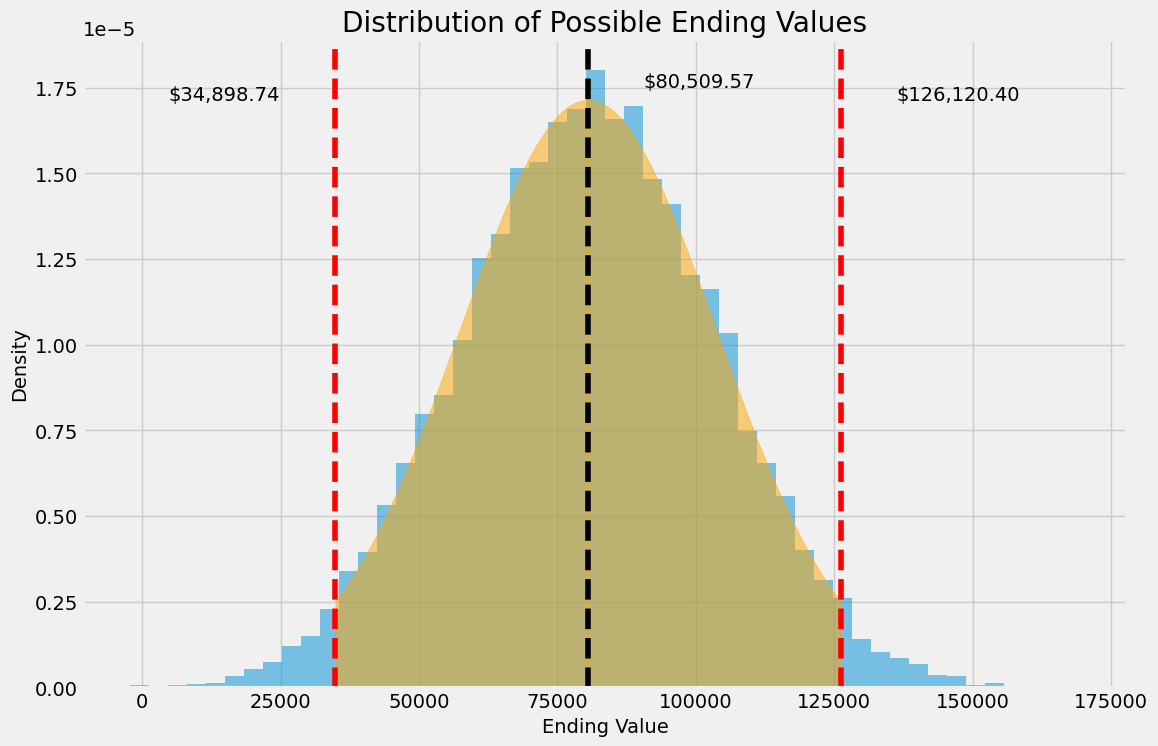

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
mean_return = 0.287
std_return = 0.372
investment = 62556
time_horizon = 1
confidence_level = 0.95

# Calculate expected ending value
expected_ending_value = investment * (1 + mean_return) ** time_horizon

# Calculate standard deviation
std_dev = investment * std_return

# Calculate z-score for given confidence level
z_score = np.abs(np.round(norm.ppf((1 - confidence_level) / 2), 2))

# Calculate confidence interval
lower_bound = expected_ending_value - z_score * std_dev
upper_bound = expected_ending_value + z_score * std_dev

# Print results
print(f"Expected ending value: {expected_ending_value:.2f}")
print(f"Confidence interval ({confidence_level:.2%}): [{lower_bound:.2f}, {upper_bound:.2f}]")

# Plot histogram of possible ending values
ending_values = np.random.normal(expected_ending_value, std_dev, 10000)
plt.hist(ending_values, bins=50, density=True, alpha=0.5)

# Shade area below lower bound
x = np.linspace(lower_bound, expected_ending_value, 100)
plt.fill_between(x, norm.pdf(x, expected_ending_value, std_dev), color='orange', alpha=0.5)

# Shade area above upper bound
x = np.linspace(expected_ending_value, upper_bound, 100)
plt.fill_between(x, norm.pdf(x, expected_ending_value, std_dev), color='orange', alpha=0.5)

# Add vertical lines and text annotations for expected ending value, lower bound, and upper bound
plt.axvline(expected_ending_value, color='black', linestyle='--')
plt.text(expected_ending_value + 20000, 1.75 * 1e-5, f"${expected_ending_value:,.2f}", ha='center')
plt.axvline(lower_bound, color='red', linestyle='--')
plt.text(lower_bound - 10000, 1.70 * 1e-5, f"${lower_bound:,.2f}", ha='right', va='bottom')
plt.axvline(upper_bound, color='red', linestyle='--')
plt.text(upper_bound + 10000, 1.70 * 1e-5, f"${upper_bound:,.2f}", ha='left', va='bottom')

# Set axis labels and title
plt.xlabel("Ending Value")
plt.ylabel("Density")
plt.title("Distribution of Possible Ending Values")

# Show plot
plt.savefig('../plots/ending_value_distribution.png')
plt.show();

## Post Processing

In [32]:
# Instantiate a instance of DiscreteAllocation
da = DiscreteAllocation(
    weights=optimal_weights,
    latest_prices=open_prices,
    total_portfolio_value=62556
)

In [33]:
# Solve integer programming problem
allocations = da.lp_portfolio(reinvest=False)
allocations

({'AMZN': 111,
  'HD': 2,
  'JPM': 5,
  'NFLX': 84,
  'NVDA': 150,
  'TSLA': 30,
  'VRTX': 7},
 29.200137772502785)

In [37]:
# Non-zero weights
non_zero_weights = {k: round(v * 100, 1) for k, v in optimal_weights.items() if v > 0}
non_zero_weights

{'AMZN': 20.8,
 'HD': 0.8,
 'JPM': 0.9,
 'NFLX': 30.6,
 'NVDA': 30.0,
 'TSLA': 13.6,
 'VRTX': 3.2}

In [34]:
da._allocation_rmse_error()

AAPL: allocated 0.000, desired 0.000
AEP: allocated 0.000, desired 0.000
AMZN: allocated 0.208, desired 0.208
BIIB: allocated 0.000, desired 0.000
CMCSA: allocated 0.000, desired 0.000
CME: allocated 0.000, desired 0.000
COST: allocated 0.000, desired 0.000
CSCO: allocated 0.000, desired 0.000
EA: allocated 0.000, desired 0.000
EBAY: allocated 0.000, desired 0.000
GOOG: allocated 0.000, desired 0.000
HD: allocated 0.009, desired 0.008
HON: allocated 0.000, desired 0.000
INTC: allocated 0.000, desired 0.000
JPM: allocated 0.009, desired 0.009
LULU: allocated 0.000, desired 0.000
META: allocated 0.000, desired 0.000
MSFT: allocated 0.000, desired 0.000
NFLX: allocated 0.307, desired 0.306
NVDA: allocated 0.300, desired 0.300
ORLY: allocated 0.000, desired 0.000
PEP: allocated 0.000, desired 0.000
PFE: allocated 0.000, desired 0.000
QCOM: allocated 0.000, desired 0.000
SBUX: allocated 0.000, desired 0.000
TSLA: allocated 0.136, desired 0.136
TXN: allocated 0.000, desired 0.000
VRTX: alloc

0.0003524300066332074